# Getting Started with Qiskit

In this example we will look at a simple quantum circuit that will create a bell state, specifically:
\begin{align}
    |\psi\rangle = \frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right)
\end{align}
This is done by first applying a Hadamard gate to $q_0$ and then applying a CNOT gate using $q_0$ as the control qubit. This will first create the following state as an intermediary
\begin{align}
    |\psi\rangle = \frac{1}{\sqrt{2}} \left( |0\rangle + |1\rangle \right) \otimes |0\rangle = \frac{1}{\sqrt{2}} \left( |00\rangle + |10\rangle \right)
\end{align}
Then the application of the CNOT gate will give the desired Bell state.

To explore this, we will measure a set of observables and then use a sampler to explore the measurement results of the circuit.

But first, to prove it works we can use QuTip to explore the circuit

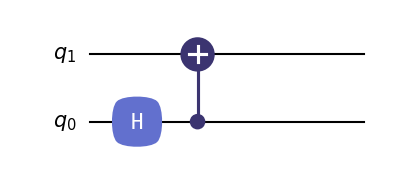

In [2]:
from qutip import tensor, basis, bell_state
from qutip_qip.circuit import QubitCircuit

qc = QubitCircuit(2)
qc.add_gate("H", 0)
qc.add_gate("CNOT", 1, 0)
qc.draw()

# Watch out, the order of the qubits is reversed in QuTip, 
# so the Qiskit model will have a slightly different visualisation

In [3]:
# initialise a |00> state
psi = tensor(basis(2, 0), basis(2, 0))
# run the circuit, this will give the state vector at the end of execution
res = qc.run(psi) # (0.707, 0, 0, 0.707)
# Compare with the QuTip Bell state
res == bell_state('00')

True

## Primitives

[Introduction to Primitives](https://quantum.cloud.ibm.com/docs/en/guides/primitives#sampler)

In Qiskit, primitives are interfaces that allow two extremely common processes in quantum computation. Expectation value estimation `Estimator`, and circuit sampling `Sampler`. The goal here is to allow developers to focus on algorithm development, and to ignore the technical details of data conversion and flow.

The input of a primitivie is a (list of) PUB (Primitive Unified Bloc).
[Primitive Inputs and Outputs](https://quantum.cloud.ibm.com/docs/en/guides/primitive-input-output)
The exact format will be explained in the relevant sections later on

## Using an Estimator

An Estimator primitive will run the circuit and then measure the chosen observables to estimate expectation values of selected operators. Measurements will be ignored

The `Estimator` PUB should contain:
- A single QuantumCircuit, which may contain one or more Parameter objects
- A list of one or more observables, which specify the expectation values to estimate, arranged into an array (for example, a single observable represented as a 0-d array, a list of observables as a 1-d array, and so on). The data can be in any one of the ObservablesArrayLike format such as Pauli, SparsePauliOp, PauliList, or str.
- A collection of parameter values to bind the circuit against. This can be specified as a single array-like object where the last index is over circuit Parameter objects, or omitted (or equivalently, set to None) if the circuit has no Parameter objects.
- (Optionally) a target precision for expectation values to estimate

`(<single circuit>, <one or more observables>, <optional one or more parameter values>, <optional precision>)`

First we build the circuit, without measurements, as required by the Estimator.

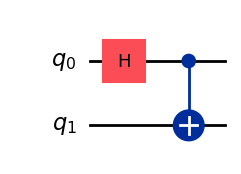

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager

qre = QuantumRegister(2, 'q')
# cre = ClassicalRegister(2, 'meas') # no need for classical register here   
qce = QuantumCircuit(qre)

qce.h(0)
qce.cx(0, 1)

obs_labels = ['II', 'IZ', 'IX', 'ZI', 'XI', 'ZX', 'ZZ', 'XX']
observables = [SparsePauliOp(label) for label in obs_labels]

qce.draw('mpl')

Here we want to measure the correlations between the two single-qubit systems. Since we know that we are creating a Bell state, which inherently has perfect correlation, we expect the $\langle ZZ \rangle$ and $\langle XX \rangle$ EVs to be 1, meaning that Z and X expectation values for the combined system are in sync. But this does not go for the local observables (the ones involving the Identity operator on a single qubit, and the Z- or X-operator on the other one). This can be understood by looking at the reduced density matrix of the components of the entangled system. This indicates that the system is in a maximally mixed state. Which means that locally, the probability is 50-50 between getting $|0\rangle$ and $|1\rangle$

In [5]:
import qiskit_ibm_runtime as qir
import qiskit_ibm_runtime.fake_provider as fp

# The local simulation needs a simulation backend to run the circuit
Backend = fp.FakeAlmadenV2
# Together with a qiskit primitive. This can be an Estimator or a Sampler.
Primitive = qir.EstimatorV2

# We can then instantiate the backend and link it to the correct primitive
backend = Backend()
estimator = Primitive(backend)

# Then set up the pass manager 
# https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.PassManager
# and transpilation to an ISA (Instruction Set Architecture) circuit
# https://www.ibm.com/quantum/blog/isa-circuits
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qce)
mapped_observables = [obs.apply_layout(isa_circuit.layout) for obs in observables]

# finally we can run the transpiled circuit, together with the desired observables
# This results in a job. In this case it runs locally, but otherwise it holds a reference to a backend job on the server.
job = estimator.run([(isa_circuit, mapped_observables)])
# We can extract the results from the job
results = job.result()[0]

for obs, result in zip(observables, results.data.evs):
    print(obs.paulis, result)

['II'] 1.0
['IZ'] 0.037109375
['IX'] -0.0048828125
['ZI'] 0.04150390625
['XI'] 0.03466796875
['ZX'] -0.0166015625
['ZZ'] 0.9033203125
['XX'] 0.89208984375


The results are then a list of the expectation values of the chosen operators. In this case, you can see that the correlation between the Z-measurements and the X-measurements is 1, while the expectation value of any combination with an identity measurement is close to 0. Indicating that we have created an entangled state. We can make this even more insightful by plotting the correlations:

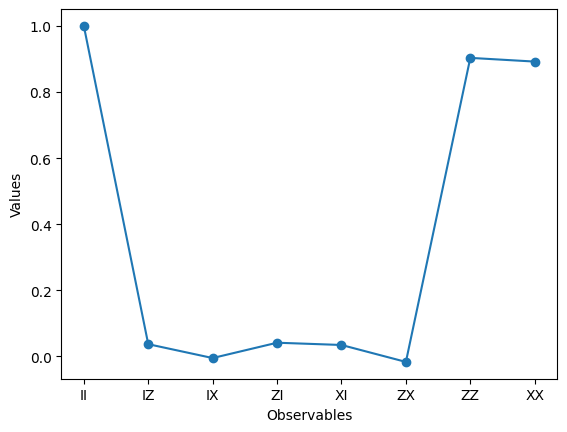

In [6]:
import matplotlib.pyplot as plt
 
values = results.data.evs
 
errors = results.data.stds
 
# plotting graph
plt.plot(obs_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

Where $\langle II \rangle$ is included as a sanity check.

### Using a Sampler

A sampler samples output registers for the selected quantum circuits. The sampler requires measurements for the system quantum registers that need to be sampled.

The `Sampler` PUB contains:
- A single QuantumCircuit, which may contain one or more Parameter objects Note: These circuits should also include measurement instructions for each of the qubits to be sampled.
- A collection of parameter values to bind the circuit against $\theta_k$ (only needed if any Parameter objects are used that must be bound at runtime)
(Optionally) a number of shots to measure the circuit with

`(<single circuit>, <one or more optional parameter value>, <optional shots>)`

First we need to make a new circuit that contains measurements, otherwise the sampler will have nothing to sample.

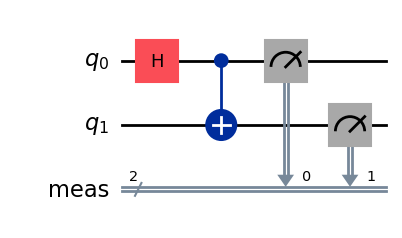

In [7]:
qrs = QuantumRegister(2, 'q')
crs = ClassicalRegister(2, 'meas')
qcs = QuantumCircuit(qrs, crs)

qcs.h(0)
qcs.cx(0, 1)
qcs.measure(qrs, crs)

qcs.draw('mpl')

In [8]:
Backend = fp.FakeAlmadenV2
Primitive = qir.SamplerV2

backend = Backend()
sampler = Primitive(backend)

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qcs)
job = sampler.run([isa_circuit], shots=1000)
results = job.result()

In [9]:
results[0].data.meas.get_counts()

{'11': 460, '00': 494, '01': 28, '10': 18}

We confirm the previous result from our Estimator. The only measurements we get are correlated. Meaning we have an entangled state.

## Generalising running circuits

As a nice next step, and to make running circuits a bit easier, we can make a new function that handles the backend and estimator setup for us. This will reduce flexibility a little bit. But can give more freedom to test things out with broad strokes.

In [10]:
from typing import Iterable, Type
from qiskit.primitives.base import BaseEstimatorV2
from qiskit.primitives.containers import EstimatorPubLike
from qiskit_ibm_runtime.fake_provider.fake_backend import FakeBackendV2

# Generalised function that takes a circuit, a set of observables, a backend type and an estimator type.
# The function instantiates all necessary parts, transpiles the circuit, and runs it on the chosen backend
def get_simulation_results_estimator(qc: QuantumCircuit, observables: Iterable[EstimatorPubLike], backend: Type[FakeBackendV2], estimator: Type[BaseEstimatorV2]):

    _backend = backend()
    _estimator = estimator(_backend)
    pm = generate_preset_pass_manager(backend=_backend, optimization_level=3)
    isa_circuit = pm.run(qc)
    mapped_observables = [obs.apply_layout(isa_circuit.layout) for obs in observables]
    job = _estimator.run([(isa_circuit, mapped_observables)])
    return job.result()[0].data

In [11]:
from qiskit_ibm_runtime import EstimatorV2
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
res = get_simulation_results_estimator(qce, observables, FakeAlmadenV2, EstimatorV2)

res.evs, res.stds

(array([ 1.        ,  0.        ,  0.01074219,  0.05615234,  0.02783203,
        -0.00927734,  0.91259766,  0.89892578]),
 array([0.        , 0.015625  , 0.0156241 , 0.01560035, 0.01561895,
        0.01562433, 0.00638842, 0.00684533]))

The function above is just a quick helper for running simple experiments without having to worry about setting up the environment every time. Especially with local simulations this makes prototyping a bit quicker and easier.